In [23]:
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error \
    , accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import pandas as pd
import os
import kagglehub

home = os.environ.get("HOME")
file_name = "heart_attack_prediction_dataset.csv"
data_path = f"{home}/.cache/kagglehub/datasets/iamsouravbanerjee/heart-attack-prediction-dataset/versions/2/{file_name}"

if not os.path.exists(data_path):
    # Download latest version
    path = kagglehub.dataset_download("iamsouravbanerjee/heart-attack-prediction-dataset")
    data_path = os.path.join(path, file_name)
    print("Path to dataset files:", data_path)

In [24]:
schema = {
	"Patient ID": "object",
	"Age": "int32",
	"Sex": "object",
	"Cholesterol": "int32",
	"Blood Pressure": "object",
	"Heart Rate": "int32",
	"Diabetes": "int8",
	"Family History": "int8",
	"Smoking": "int8",
	"Obesity": "int8",
	"Alcohol Consumption": "int32",
	"Exercise Hours Per Week": "float32",
	"Diet": "object",
	"Previous Heart Problems": "int32",
	"Medication Use": "int32",
	"Stress Level": "int32",
	"Sedentary Hours Per Day": "float32",
	"Income": "int32",
	"BMI": "float32",
	"Triglycerides": "int32",
	"Physical Activity Days Per Week": "int32",
	"Sleep Hours Per Day": "int32",
	"Country": "object",
	"Continent": "object",
	"Hemisphere": "object",
	"Heart Attack Risk": "int8"
}
data = pd.read_csv(data_path, dtype=schema)
data.describe()

,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk
count,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000
mean,53.707977,259.877211,75.021682,0.652288,0.492982,0.896839,0.501426,0.598083,10.014284,0.495835,0.498345,5.469702,5.993690,158263.181901,28.891445,417.677051,3.489672,7.023508,0.358211
std,21.249509,80.863276,20.550948,0.476271,0.499979,0.304186,0.500026,0.490313,5.783746,0.500011,0.500026,2.859622,3.466359,80575.190806,6.319181,223.748137,2.282687,1.988473,0.479502
min,18.000000,120.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002442,0.000000,0.000000,1.000000,0.001263,20062.000000,18.002337,30.000000,0.000000,4.000000,0.000000
25%,35.000000,192.000000,57.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.981579,0.000000,0.000000,3.000000,2.998794,88310.000000,23.422985,225.500000,2.000000,5.000000,0.000000
50%,54.000000,259.000000,75.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.069559,0.000000,0.000000,5.000000,5.933622,157866.000000,28.768999,417.000000,3.000000,7.000000,0.000000
75%,72.000000,330.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.050018,1.000000,1.000000,8.000000,9.019125,227749.000000,34.324594,612.000000,5.000000,9.000000,1.000000
max,90.000000,400.000000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.998709,1.000000,1.000000,10.000000,11.999313,299954.000000,39.997211,800.000000,7.000000,10.000000,1.000000


In [25]:
data.head(5)

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615002,261404,31.251232,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464703,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809145,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [26]:
import re

def clean_column_names(df):
    df.columns = [re.sub(r'\s', '_', str(col).lower()) for col in df.columns]

clean_column_names(data)

In [27]:
for col, dtyp in zip(data.columns, data.dtypes):
    print(f"\"{col}\": \"{dtyp}\",")

"patient_id": "object",
"age": "int32",
"sex": "object",
"cholesterol": "int32",
"blood_pressure": "object",
"heart_rate": "int32",
"diabetes": "int8",
"family_history": "int8",
"smoking": "int8",
"obesity": "int8",
"alcohol_consumption": "int32",
"exercise_hours_per_week": "float32",
"diet": "object",
"previous_heart_problems": "int32",
"medication_use": "int32",
"stress_level": "int32",
"sedentary_hours_per_day": "float32",
"income": "int32",
"bmi": "float32",
"triglycerides": "int32",
"physical_activity_days_per_week": "int32",
"sleep_hours_per_day": "int32",
"country": "object",
"continent": "object",
"hemisphere": "object",
"heart_attack_risk": "int8",


In [28]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def mmp(x, prob, actual, title):
    """
    Marginal Model Plots for Binary Model Fit Validation
    Based on methodology established by Weisberg, 2005.
    """
    yhat = lowess(endog=prob, exog=x, frac=.2, it=0)
    x1 = yhat[:,0]
    y1 = yhat[:,1]

    Y = lowess(endog=actual, exog=x, frac=.2, it=0)
    x2 = Y[:,0]
    y2 = Y[:,1]
    
    fig1, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(x1, y1, color='blue', alpha=0.7)
    ax2.plot(x2, y2, color='red', alpha=0.7)
    ax1.set_title(title)
    ax1.set_ylabel('Actual + Prob')
    ax1.set_xlabel('X')
    plt.show()

def get_elasticnet(X, y, column_names, max_iter=10000):
    """
    Select significant variables according to Elastic Net.
    @param X <Pandas Dataframe>
    @param y <list>
    @columns <list>
    @max_iter <int>
    @returns <list>
    """ 
    def get_mse(alpha):
        model = ElasticNet(alpha=a, max_iter=max_iter).fit(X, y)   
        score = model.score(X, y)
        pred_y = model.predict(X)
        return mean_squared_error(y, pred_y)
        
    lowest_mse = 1.0
    best_alpha = 0.0
    alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
    
    for a in alphas:
        mse = get_mse(a)
        if mse < lowest_mse:
            lowest_mse = mse
            best_alpha = a
        
    clf = ElasticNet(alpha=best_alpha, max_iter=max_iter)
    sfm = SelectFromModel(clf)
    sfm.fit(X, y)
    feature_indices = sfm.get_support()
    significant_features = []
    for c, b in zip(column_names, feature_indices):
        if b:
            significant_features.append(c)

    return significant_features

def get_balanced_accuracy(tpr, fpr):
    """
    Return average of Sensitivity and Specificity.
    """
    return (tpr + (1-fpr)) / 2

def get_tpr_fpr(cm):
    """
    Sensitivity: TruePos / (True Pos + False Neg) 
    Specificity: True Neg / (False Pos + True Neg)
    TN | FP
    -------
    FN | TP
    @param 2D array <list<list>>
    @returns <list<float>>
    """
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])

    tpr = tp / (tp + fn)
    fpr = 1-(tn / (fp + tn))

    return [tpr, fpr]

def get_best_cutoff(actual, prob):  
    """
    Get the best cutoff according to Balanced Accuracy
    'Brute-force' technique - try all cutoffs from 0.01 to 0.99 in increments of 0.01

    @param actual <list<float>>
    @param prob <list<tuple<float, float>>>
    @returns <list<float>>
    """
    best_tpr = 0.0; best_fpr = 0.0; best_cutoff = 0.0; best_ba = 0.0; 
    cutoff = 0.0
    cm = [[0,0],[0,0]]
    while cutoff < 1.0:
        pred = list(map(lambda p: 1 if p >= cutoff else 0, prob))
        _cm = confusion_matrix(actual, pred)
        _tpr, _fpr = get_tpr_fpr(_cm)

        if(_tpr < 1.0):    
            ba = get_balanced_accuracy(tpr=_tpr, fpr=_fpr)

            if(ba > best_ba):
                best_ba = ba
                best_cutoff = cutoff
                best_tpr = _tpr
                best_fpr = _fpr
                cm = _cm

        cutoff += 0.01

    tn = cm[0][0]; fp = cm[0][1]; fn = cm[1][0]; tp = cm[1][1];
    return [best_tpr, best_fpr, best_cutoff, tn, fp, fn, tp]
    
# create confusion matrix
def get_predict_frame(actual, prob, model_name='Logit'):
    """
    Compute predicted based on estimated probabilities and best threshold. 
    Output predictions and confusion matrix.
    """
    # calculate TPR, FPR, best probability threshold
    tpr, fpr, cutoff, tn, fp, fn, tp = get_best_cutoff(actual, prob)
    accuracy = get_balanced_accuracy(tpr, fpr)
    auc = roc_auc_score(actual, prob)
    
    #print("Optimal prob. threshold is %0.3f: " % cutoff)
    yhat = list(map(lambda p: 1 if p >= cutoff else 0, prob))
    stats = pd.DataFrame(columns=['Model', 'TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity', 'Cutoff', 'Accuracy', 'AUC'],
                data=[[model_name, tp, fp, tn, fn, tpr, (1-fpr), cutoff, accuracy, auc]])

    print("Sensitivity: {0:.3f}%, Specificity: {1:.3f}%, Threshold: {2:.3f}".format(tpr*100, (1-fpr)*100, cutoff))
    return yhat, stats

def plot_roc(actual, prob):
    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(actual, prob)

    # plot ROC curve
    fig = plt.figure(figsize=(10, 10))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.show()

In [29]:
# Check for missing data
data.isnull().sum()

patient_id                         0
age                                0
sex                                0
cholesterol                        0
blood_pressure                     0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
country                            0
continent                          0
hemisphere                         0
heart_attack_risk                  0
dtype: int64

In [30]:
# Check for rows with nulls
data[data.isnull().any(axis=1)]

,patient_id,age,sex,cholesterol,blood_pressure,heart_rate,diabetes,family_history,smoking,obesity,...,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,country,continent,hemisphere,heart_attack_risk


In [31]:
def get_age_group(age: int) -> str:
    if age >= 18 and age <= 24:
        return "18 to 24"
    if age >= 25 and age <= 34:
        return "25 to 34"
    if age >= 35 and age <= 44:
        return "35 to 44"
    if age >= 45 and age <= 54:
        return "45 to 54"
    if age >= 55 and age <= 64:
        return "55 to 64"
    return "65 or over"

data['systolic'] = 0.0
data['systolic'] = data['systolic'].astype("int32")
data['diastolic'] = 0.0
data['diastolic'] = data['diastolic'].astype("int32")
data['age_group'] = ""
data['age_group'] = data['age_group'].astype("object")

for ix, (bp, age) in enumerate(data[["blood_pressure", "age"]].to_numpy()):
    sys, dias = bp.split("/")
    # print(ix, sys, dias, age, get_age_group(int(age)))
    data['systolic'].at[ix] = np.int32(sys)
    data['diastolic'].at[ix] = np.int32(dias)
    data['age_group'].at[ix] = get_age_group(int(age))

In [32]:
data['age_group'].head()

0    65 or over
1      18 to 24
2      18 to 24
3    65 or over
4    65 or over
Name: age_group, dtype: object

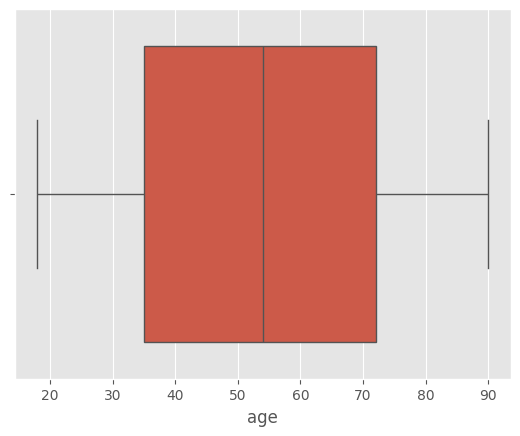

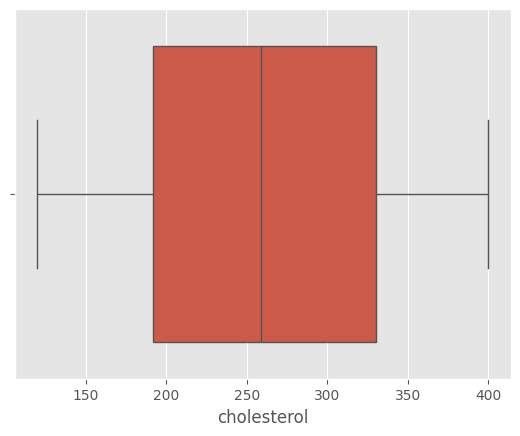

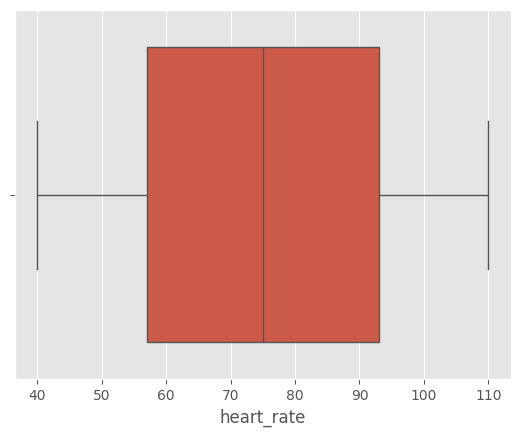

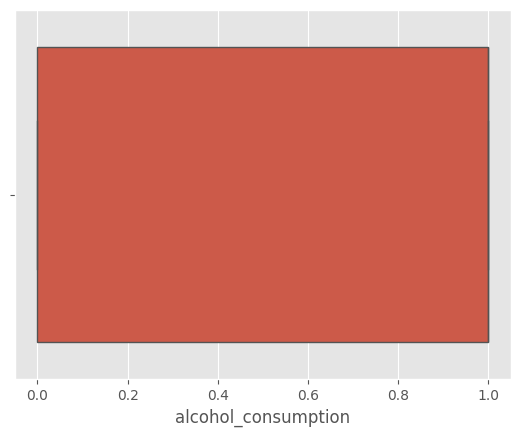

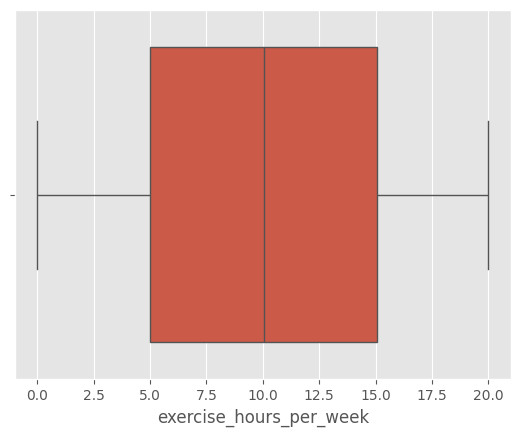

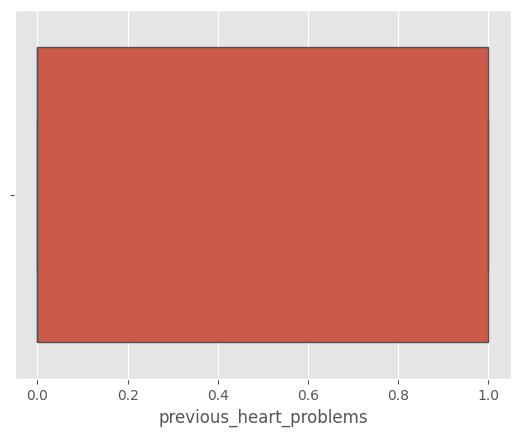

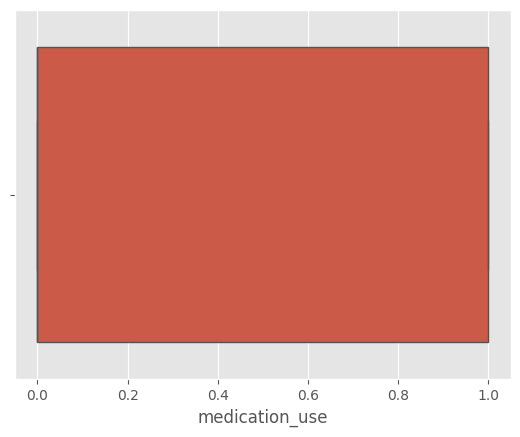

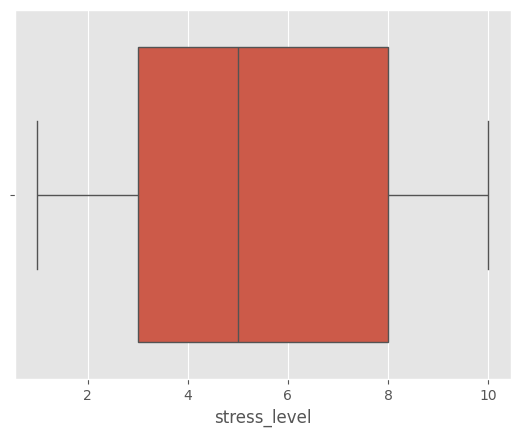

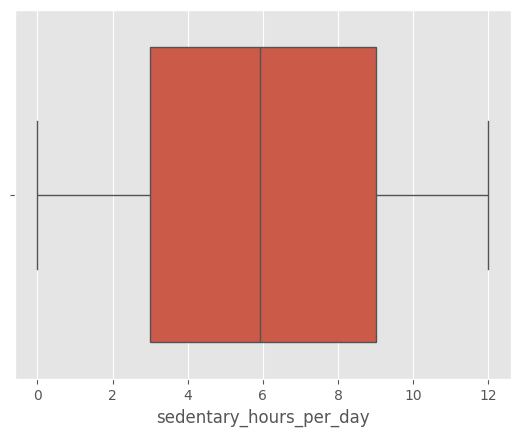

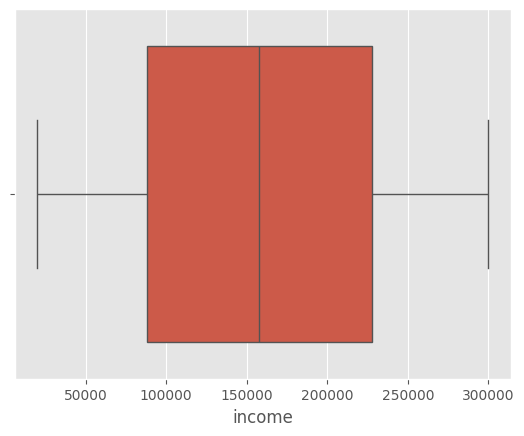

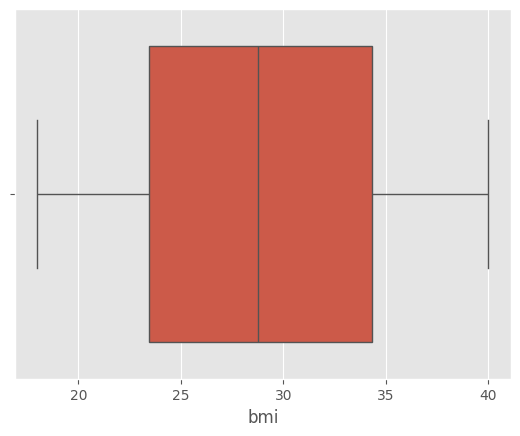

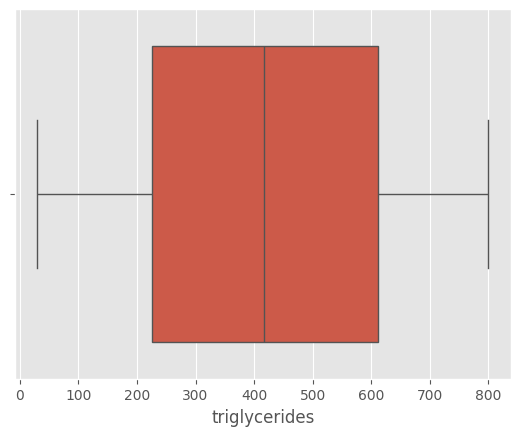

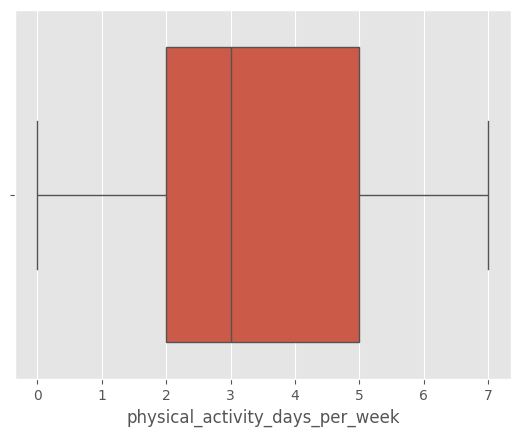

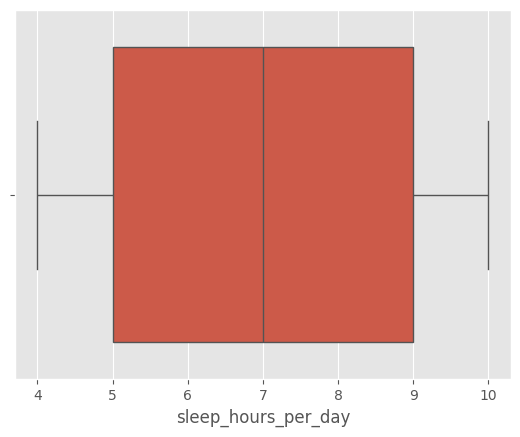

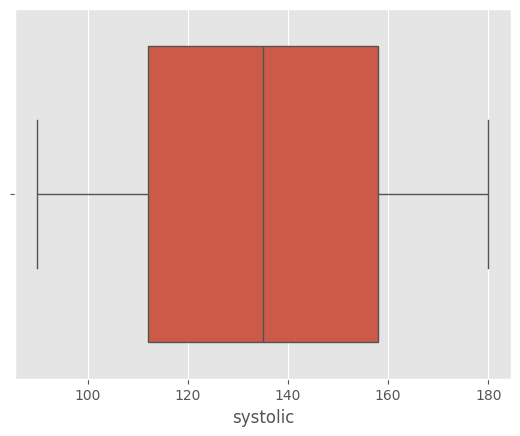

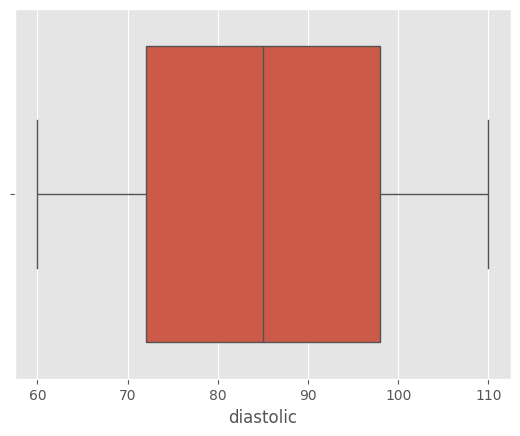

In [33]:
for col, dtype in zip(data.columns, data.dtypes):
    if not dtype in ['int32', 'float32']:
        continue
    plt.figure()
    sb.boxplot(x=data[col])
    plt.show()

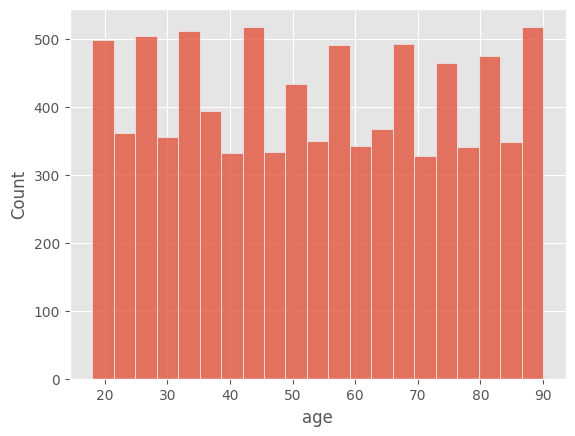

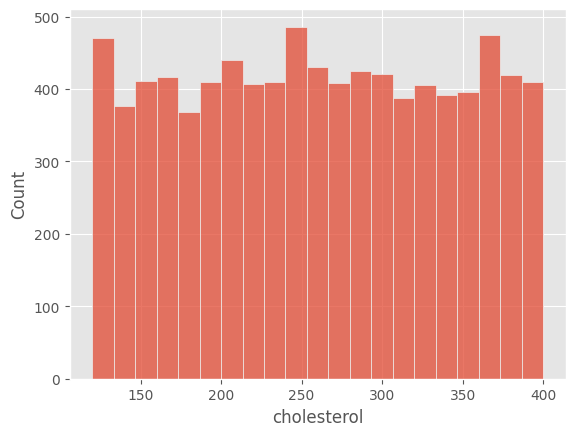

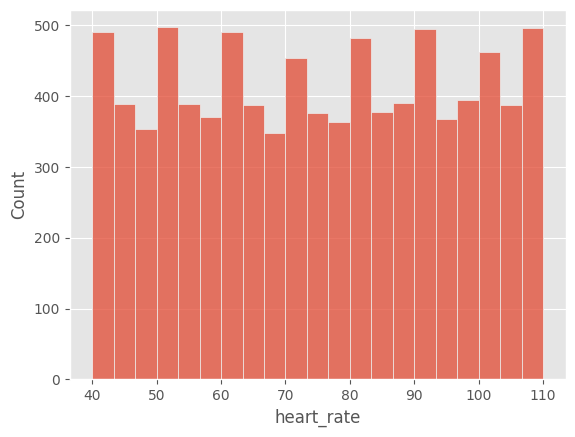

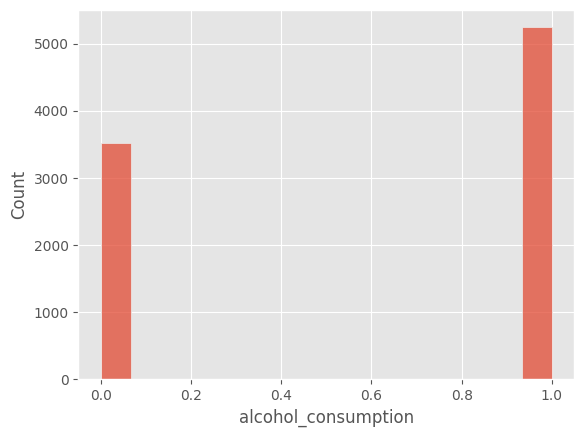

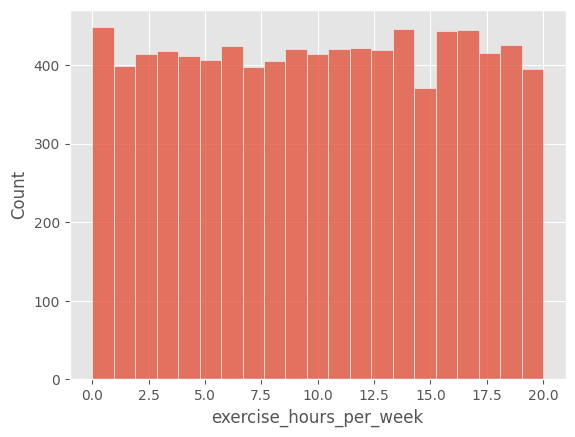

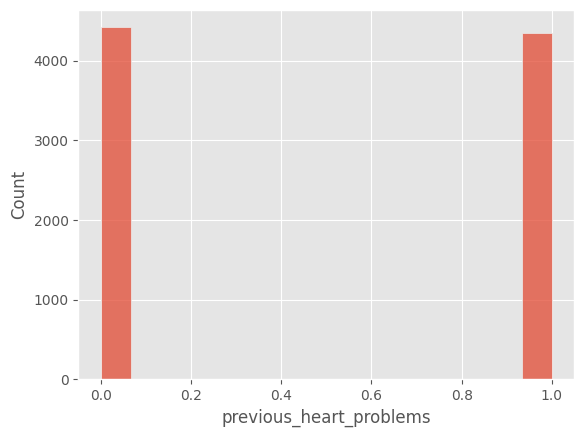

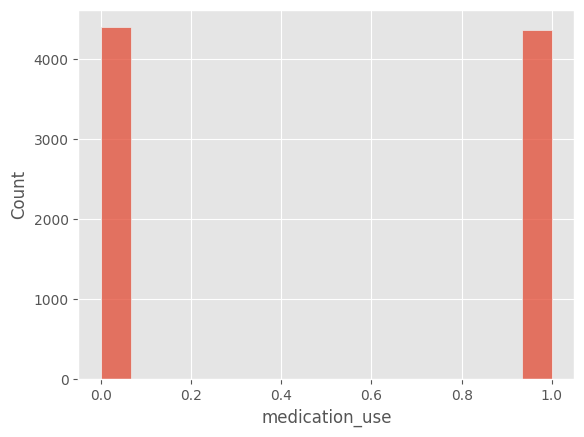

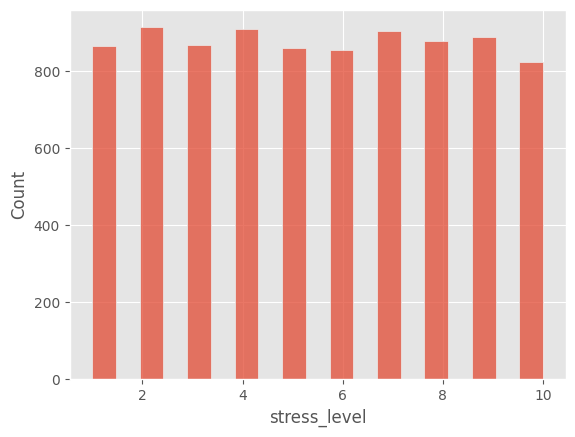

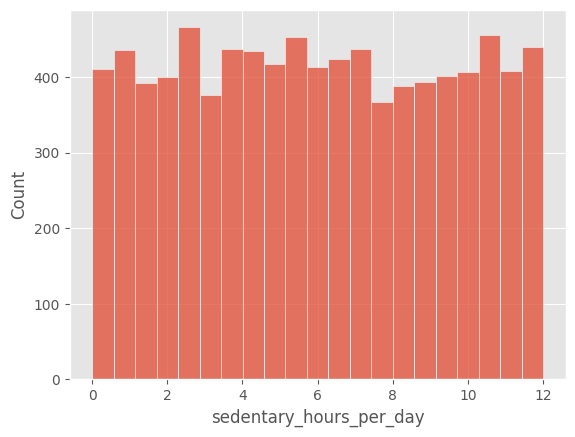

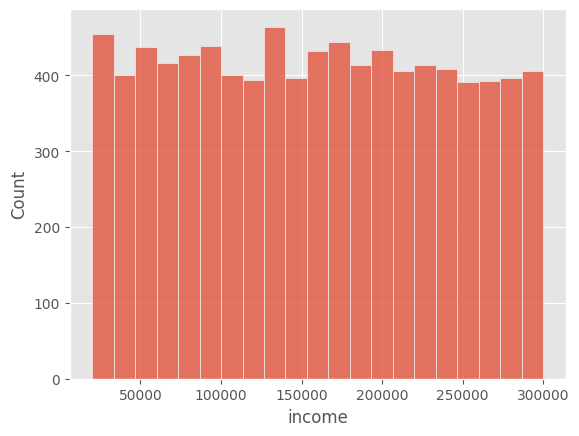

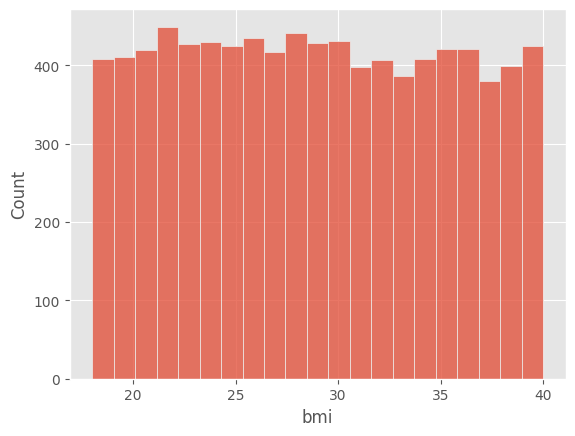

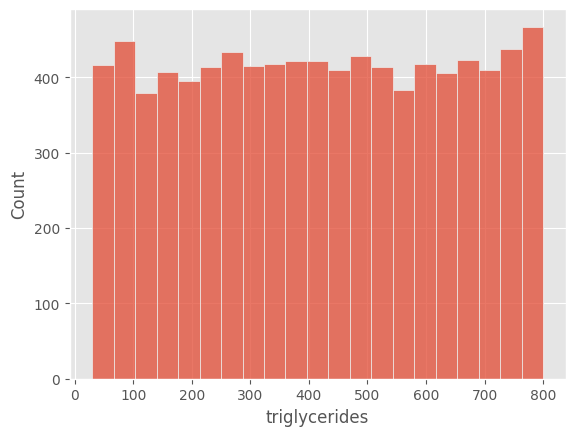

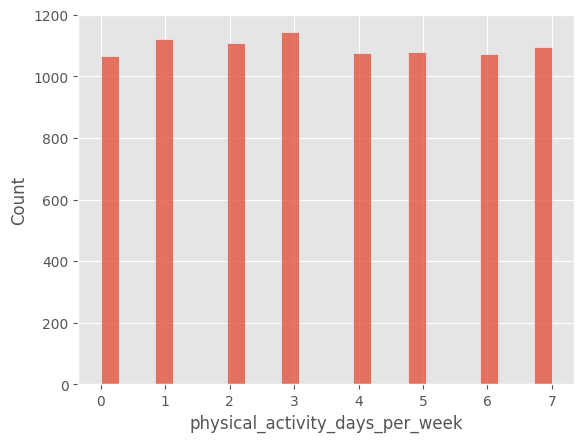

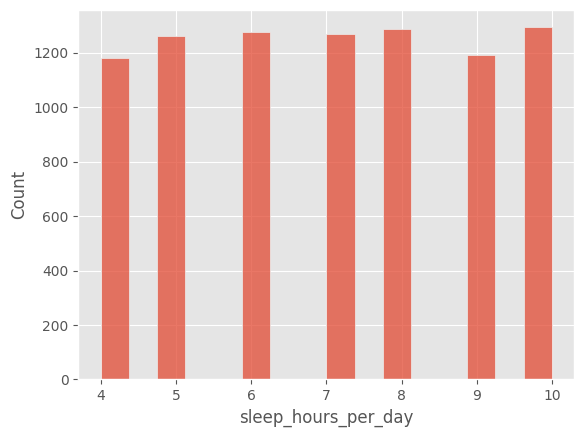

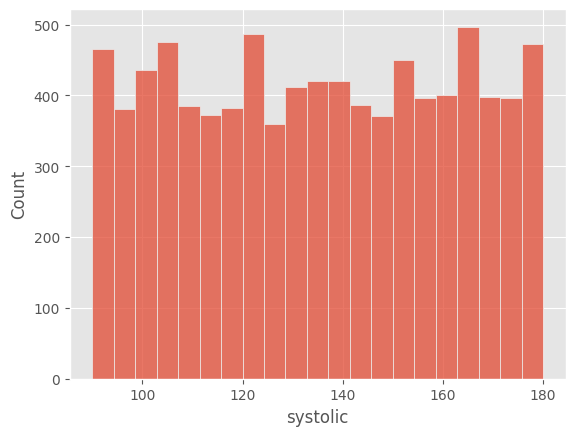

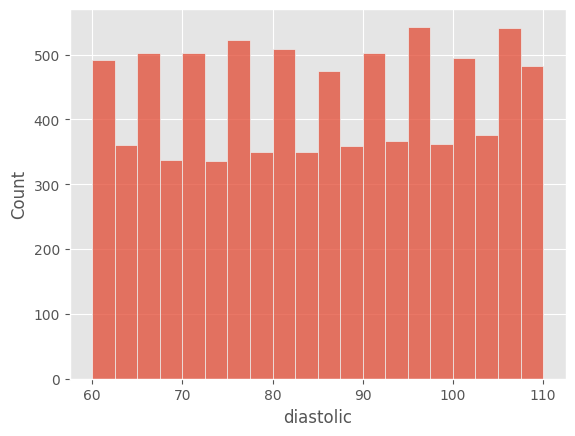

In [34]:
for col, dtype in zip(data.columns, data.dtypes):
    if not dtype in ['int32', 'float32']:
        continue
    plt.figure()
    sb.histplot(x=data[col])
    plt.show()

In [35]:
TARGET = "heart_attack_risk"
# Is this a rare event problem where the minority class < 2%.
pos = data[(data[TARGET] == True)]
neg = data[(data[TARGET] == False)]
ratio = len(pos) / len(data)*100
print(str.format("The ratio of True ({}) to False ({}) is {:.3f}% to {:.3f}%.", \
                 len(pos), len(neg), ratio, 100-ratio))

The ratio of True (3139) to False (5624) is 35.821% to 64.179%.


In [36]:
try:
    df = data.drop(labels=["patient_id", "continent", "hemisphere", "blood_pressure", "age"], axis=1).copy()
finally:
    pass
df = pd.get_dummies(df)
clean_column_names(df)

In [37]:
df.columns

Index(['cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking',
       'obesity', 'alcohol_consumption', 'exercise_hours_per_week',
       'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk', 'systolic', 'diastolic', 'sex_female', 'sex_male',
       'diet_average', 'diet_healthy', 'diet_unhealthy', 'country_argentina',
       'country_australia', 'country_brazil', 'country_canada',
       'country_china', 'country_colombia', 'country_france',
       'country_germany', 'country_india', 'country_italy', 'country_japan',
       'country_new_zealand', 'country_nigeria', 'country_south_africa',
       'country_south_korea', 'country_spain', 'country_thailand',
       'country_united_kingdom', 'country_united_states', 'country_vietnam',
       'age_group_18_to_24', 'age_group_25_to_34', 'age_group_35_to_44',
    

In [38]:
features = df.copy() if not(TARGET in list(df.columns)) else df.drop(labels=[TARGET], axis=1).copy()
target = df[TARGET].copy()
column_names = features.columns

x_train, x_val, y_train, y_val = train_test_split(
    features,
    target,
    test_size=0.1,
    random_state=42
)
print(len(x_train), len(x_val))

7886 877


In [39]:
# ElasticNet feature selection for significant predictors
sig_features = get_elasticnet(x_train, y_train, column_names)
sig_features

['diabetes',
 'obesity',
 'alcohol_consumption',
 'country_australia',
 'country_colombia',
 'country_india',
 'country_italy',
 'country_japan',
 'country_nigeria',
 'country_south_africa',
 'country_south_korea',
 'country_spain',
 'country_thailand',
 'country_united_states',
 'age_group_18_to_24',
 'age_group_35_to_44',
 'age_group_45_to_54',
 'age_group_55_to_64']

In [40]:
# Create formula string
formula = TARGET + " ~ " + " + ".join(sig_features)
formula

'heart_attack_risk ~ diabetes + obesity + alcohol_consumption + country_australia + country_colombia + country_india + country_italy + country_japan + country_nigeria + country_south_africa + country_south_korea + country_spain + country_thailand + country_united_states + age_group_18_to_24 + age_group_35_to_44 + age_group_45_to_54 + age_group_55_to_64'

In [41]:
train = x_train.copy()
train[TARGET] = y_train
sm_logit = smf.logit(formula=formula, data=train).fit()
sm_logit.summary2()

Optimization terminated successfully.
         Current function value: 0.649532
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
=============================================================================
Model:                   Logit                Method:              MLE       
Dependent Variable:      heart_attack_risk    Pseudo R-squared:    0.004     
Date:                    2025-01-24 12:33     AIC:                 10282.4230
No. Observations:        7886                 BIC:                 10414.9070
Df Model:                18                   Log-Likelihood:      -5122.2   
Df Residuals:            7867                 LL-Null:             -5143.0   
Converged:               1.0000               LLR p-value:         0.0012517 
No. Iterations:          5.0000               Scale:               1.0000    
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                     -0.5526   0.0641 -8.6227 0.0000 -0.6782 -0.4270
country_australia[T.True]      0.0975   0.1089  0.8956 0.3704 -0.1159  0.3109
country_colombia[T.True]       0.1099   0.1111  0.9888 0.3227 -0.1079  0.3277
country_india[T.True]         -0.1641   0.1169 -1.4031 0.1606 -0.3932  0.0651
country_italy[T.True]         -0.2274   0.1165 -1.9526 0.0509 -0.4557  0.0009
country_japan[T.True]         -0.1339   0.1137 -1.1772 0.2391 -0.3567  0.0890
country_nigeria[T.True]        0.1948   0.1059  1.8398 0.0658 -0.0127  0.4022
country_south_africa[T.True]  -0.1523   0.1159 -1.3144 0.1887 -0.3794  0.0748
country_south_korea[T.True]    0.2434   0.1111  2.1904 0.0285  0.0256  0.4611
country_spain[T.True]         -0.0497   0.1120 -0.4432 0.6577 -0.2693  0.1700
country_thailand[T.True]       0.0982   0.1106  0.8880 0.3745 -0.1186  0.3150
country_united_states[T.True]  0.1852   0.1101  1.6814 0.0927 -0.0307  0.4010
age_group_18_to_24[T.True]    -0.1196   0.0833 -1.4362 0.1509 -0.2827  0.0436
age_group_35_to_44[T.True]     0.0440   0.0706  0.6231 0.5332 -0.0944  0.1824
age_group_45_to_54[T.True]    -0.1633   0.0744 -2.1949 0.0282 -0.3091 -0.0175
age_group_55_to_64[T.True]    -0.1196   0.0725 -1.6482 0.0993 -0.2617  0.0226
diabetes                       0.1085   0.0497  2.1810 0.0292  0.0110  0.2059
obesity                       -0.0692   0.0472 -1.4677 0.1422 -0.1616  0.0232
alcohol_consumption           -0.0656   0.0480 -1.3678 0.1714 -0.1596  0.0284
=============================================================================

"""

Sensitivity: 13.249%, Specificity: 87.143%, Threshold: 0.380
Sensitivity: 4.394%, Specificity: 96.130%, Threshold: 0.390


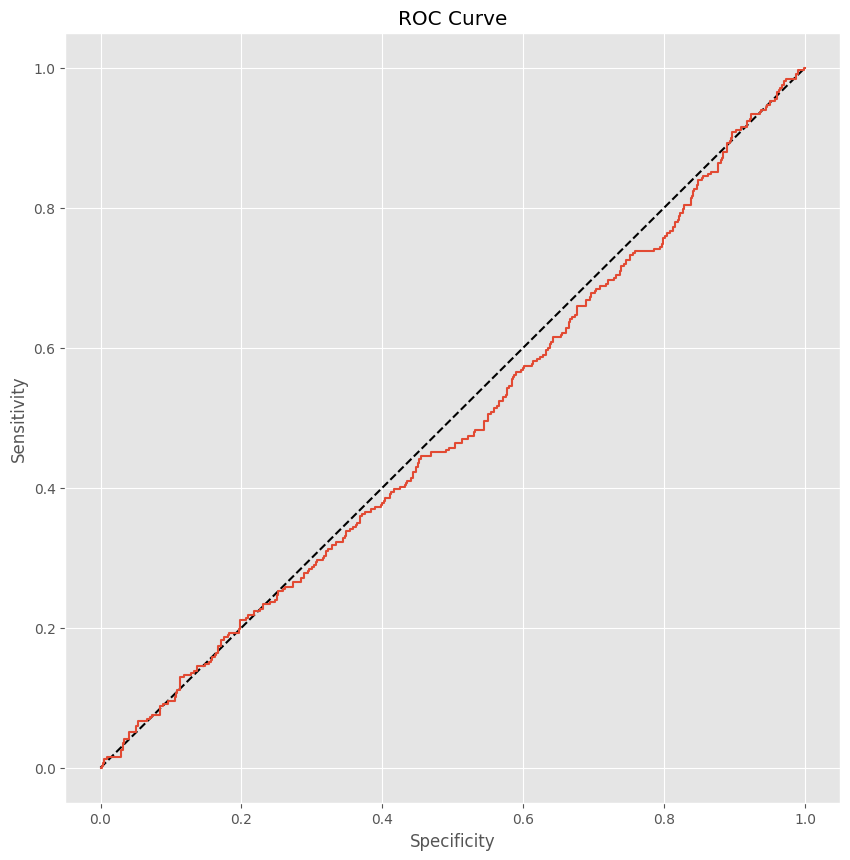

              Model  TP  FP   TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Logit Val  42  72  488  275     0.132492     0.871429    0.38   

   Accuracy       AUC  
0   0.50196  0.483275  


In [42]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
logit_model = LogisticRegression(C=1/reg, max_iter=10000, solver='liblinear').fit(x_train, y_train)

logit_predictions = logit_model.predict(x_val)
logit_y_scores = logit_model.predict_proba(x_val)
logit_y_scores_train = logit_model.predict_proba(x_train)

logit_prob = logit_y_scores[:,1]
logit_prob_train = logit_y_scores_train[:,1]
logit_yhat, logit_stats = get_predict_frame(y_val, logit_prob, 'Scikit Logit Val')
logit_yhat_train, logit_stats_train = get_predict_frame(y_train, logit_prob_train, 'Scikit Logit Train')
plot_roc(y_val, logit_prob)
print(logit_stats.head())

Sensitivity: 34.069%, Specificity: 60.357%, Threshold: 0.010


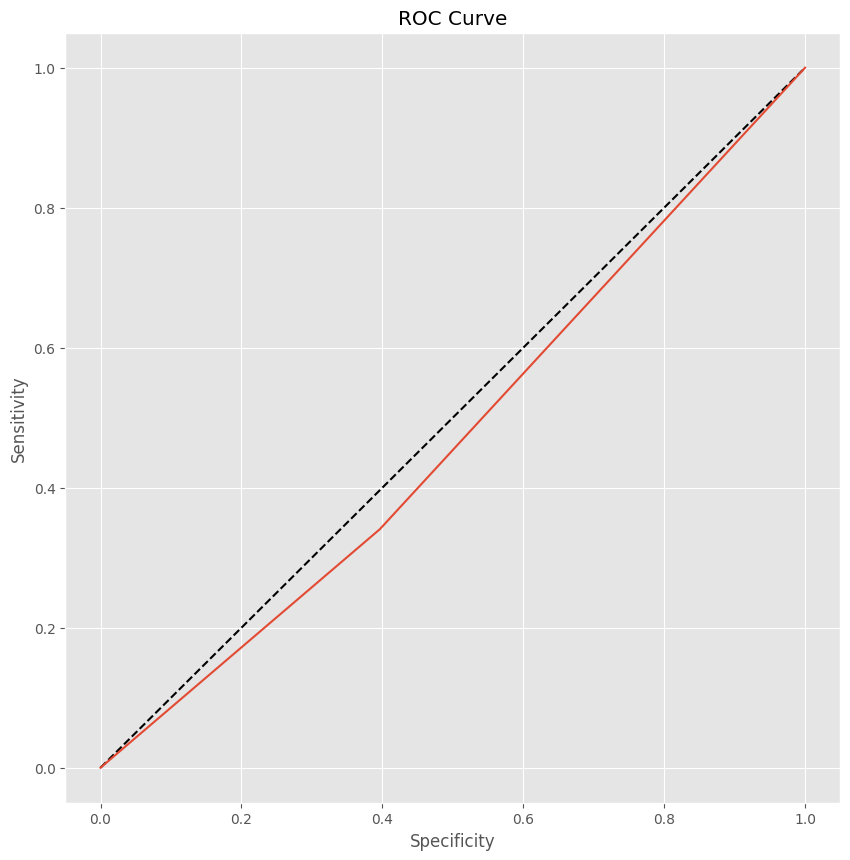

              Model   TP   FP   TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit DTree Val  108  222  338  209     0.340694     0.603571    0.01   

   Accuracy       AUC  
0  0.472133  0.472133  


In [43]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier().fit(x_train, y_train)
tree_predictions = tree_model.predict(x_val)
tree_y_scores = tree_model.predict_proba(x_val)
tree_prob = tree_y_scores[:,1]
tree_yhat, tree_stats = get_predict_frame(y_val, tree_prob, 'Scikit DTree Val')
plot_roc(y_val, tree_prob)
print(tree_stats.head())

Sensitivity: 52.997%, Specificity: 52.679%, Threshold: 0.370


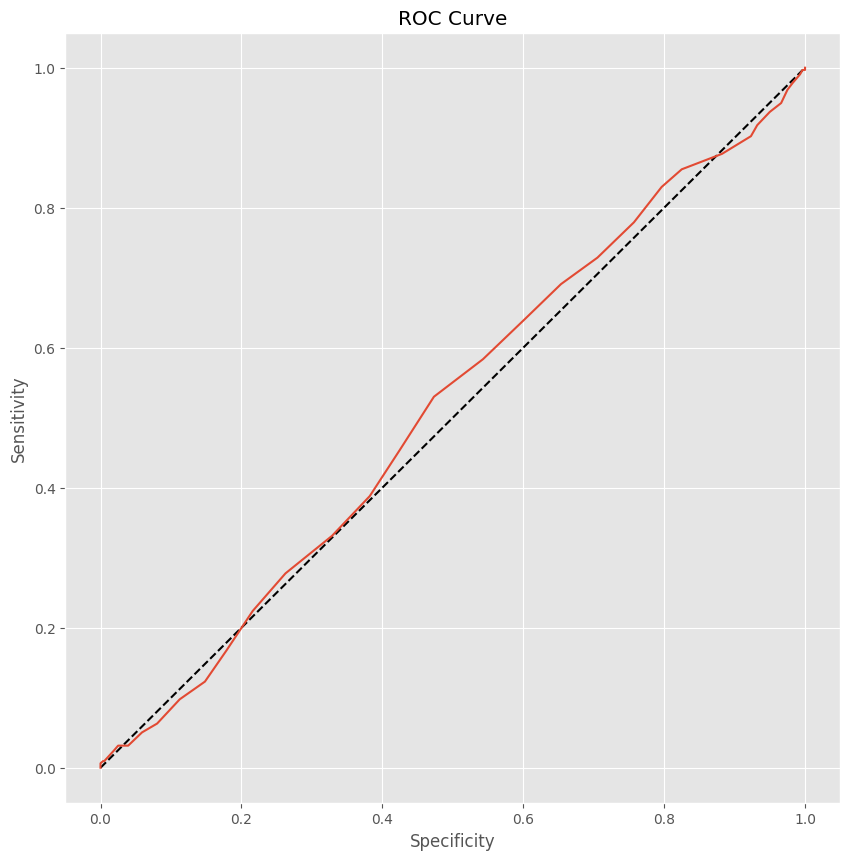

               Model   TP   FP   TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Forest Val  168  265  295  149     0.529968     0.526786    0.37   

   Accuracy       AUC  
0  0.528377  0.513793  


In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=100).fit(x_train, y_train)
forest_predictions = forest_model.predict(x_val)
forest_y_scores = forest_model.predict_proba(x_val)
forest_prob = forest_y_scores[:,1]
forest_yhat, forest_stats = get_predict_frame(y_val, forest_prob, 'Scikit Forest Val')
plot_roc(y_val, forest_prob)
print(forest_stats.head())